<a href="https://colab.research.google.com/github/bezisch/Climate_Obstruction/blob/main/ner_network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script aims at conducting a network analysis from the fossil fuel NER

For this to run, we have to upload the "Database_for_Publication_042425_withdates.xlsx" file

In [3]:
#pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
#network analysis
import networkx as nx
from itertools import combinations
#visualise network
import matplotlib.pyplot as plt
from collections import defaultdict
from pyvis.network import Network
import webbrowser

### Network Analysis

In [5]:
docs = pd.read_excel("/Database_for_Publication_042425_withdates.xlsx")

# Function to read text from a file
def read_text_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except Exception as e:
        return f"Error: {e}"

docs.shape #should be 4479 rows

FileNotFoundError: [Errno 2] No such file or directory: '/Database_for_Publication_042425_withdates.xlsx'

In [ ]:
docs.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4479 entries, 0 to 4478
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   PDF filename                      4479 non-null   object 
 1   URL                               4479 non-null   object 
 2   Folder                            4479 non-null   object 
 3   Doc Type                          4479 non-null   object 
 4   Emotions                          4458 non-null   object 
 5   Summary                           4479 non-null   object 
 6   People                            4477 non-null   object 
 7   redaction_terms_1                 4254 non-null   object 
 8   redaction_terms_2                 3634 non-null   object 
 9   redaction_count_1                 4479 non-null   int64  
 10  redaction_count_2                 4479 non-null   int64  
 11  redaction_percentage_1            4479 non-null   int64  
 12  redact

Filter variables.



In [ ]:
filtered_docs = docs[docs['Keyword Climate Environment'].notna()]
filtered_docs = filtered_docs.reset_index()


actor_columns = [
    'People',
    'Academia',
    'Consultancy',
    'Courts',
    'Energy Industry',
    'Government Agency',
    'International Climate Governance',
    'International Organization',
    'Journalist',
    'Legal Professionals',
    'Legislation',
    'Litigation',
    'Lobby',
    'NGO/Thinktank/Foundation',
    'News Outlet',
    'Other Industry',
    'PR Company',
    'Politician',
    'Judiciary',
    'Media'
]


# Create a new dataframe of booleans: actor is present if value is non-null and not just whitespace
actor_presence = filtered_docs[actor_columns].applymap(lambda x: isinstance(x, str) and x.strip() != '')


print(actor_presence.sum().sort_values(ascending=False))  # how many documents each actor appears in

People                              1192
Legislation                         1180
Energy Industry                     1134
Judiciary                            878
Litigation                           729
Government Agency                    617
Courts                               613
Lobby                                478
Politician                           476
Academia                             473
Other Industry                       449
Media                                417
News Outlet                          417
NGO/Thinktank/Foundation             375
International Organization           328
International Climate Governance     242
Legal Professionals                  240
Consultancy                           35
PR Company                            33
Journalist                             5
dtype: int64


<ipython-input-6-3336350124>:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  actor_presence = filtered_docs[actor_columns].applymap(lambda x: isinstance(x, str) and x.strip() != '')


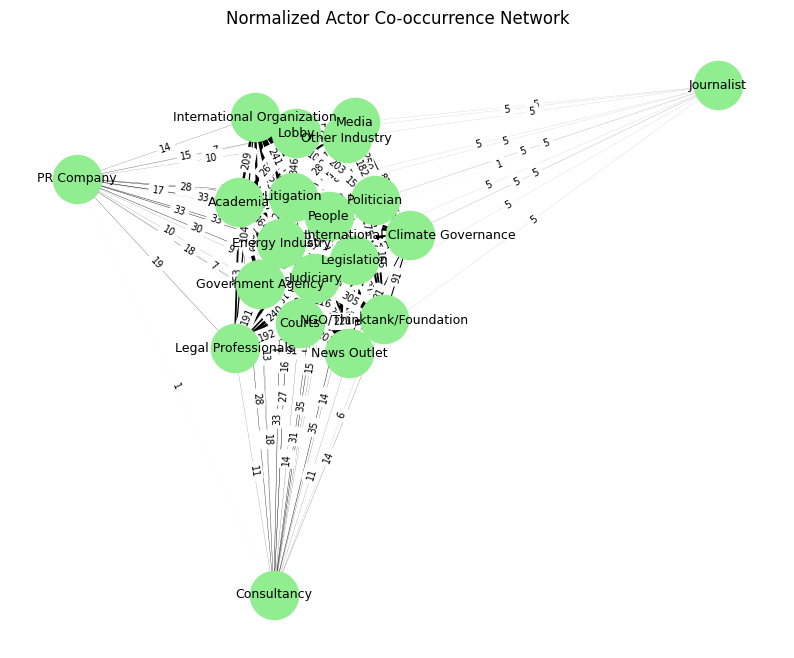

In [ ]:
#We want documents that mention at least 2 actor types (columns with True):

actor_presence['actor_count'] = actor_presence.sum(axis=1)
filtered_presence = actor_presence[actor_presence['actor_count'] >= 2]


# Build the Co-occurrence Network

G_overall = nx.Graph()

for idx, row in filtered_presence.iterrows():
    present_actors = [actor for actor in actor_columns if row[actor]]
    for actor1, actor2 in combinations(present_actors, 2):
        if G_overall.has_edge(actor1, actor2):
            G_overall[actor1][actor2]['weight'] += 1
        else:
            G_overall.add_edge(actor1, actor2, weight=1)


#Visualise the network

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_overall, seed=42)
edges = G_overall.edges(data=True)

# Normalize edge widths
max_weight = max([d['weight'] for (_, _, d) in edges])
scaled_widths = [d['weight'] / max_weight * 10 for (_, _, d) in edges]

nx.draw_networkx_nodes(G_overall, pos, node_size=1200, node_color='lightgreen')
nx.draw_networkx_labels(G_overall, pos, font_size=9)
nx.draw_networkx_edges(G_overall, pos, edgelist=edges, width=scaled_widths)

# Optional edge labels
edge_labels = {(u, v): d['weight'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G_overall, pos, edge_labels=edge_labels, font_size=7)

plt.title("Normalized Actor Co-occurrence Network")
plt.axis('off')
plt.show()

Element	Interpretation

Big node in center	Frequently co-occurs with many others

Thick edge	Strong connection (many co-occurrences)

Isolated/small node	Rarely co-occurs with others

Edge label = 35	Appeared together in 35 documents


Building network for keyword: hydrogen


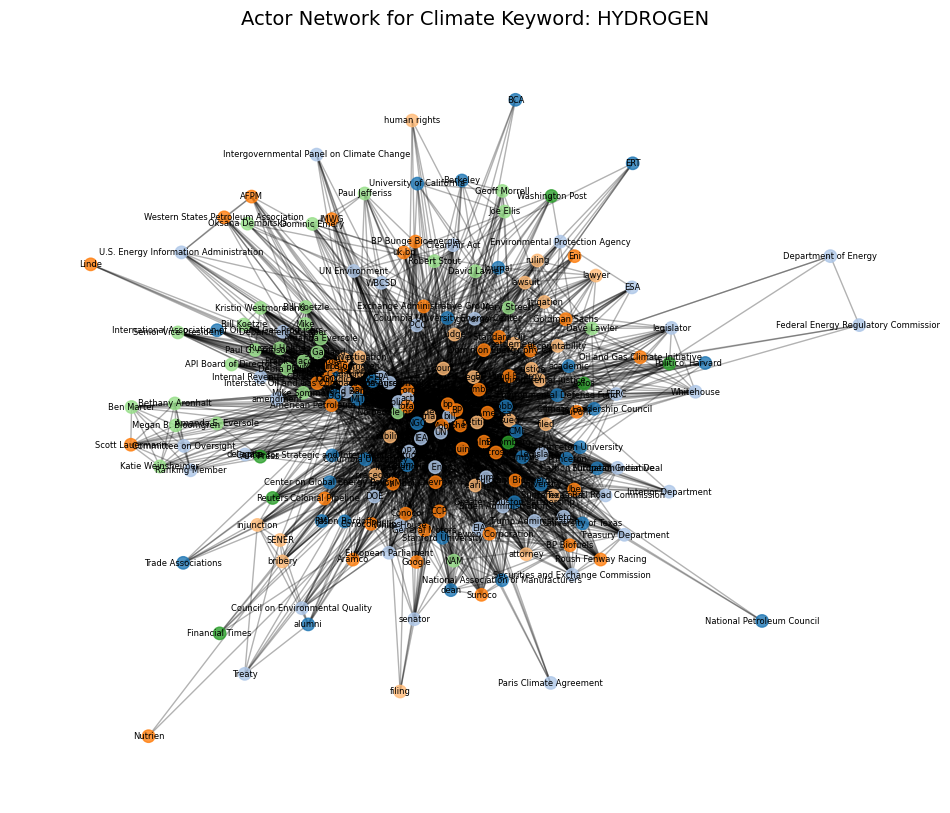


Building network for keyword: biofuels
No documents found for keyword: biofuels

Building network for keyword: algae


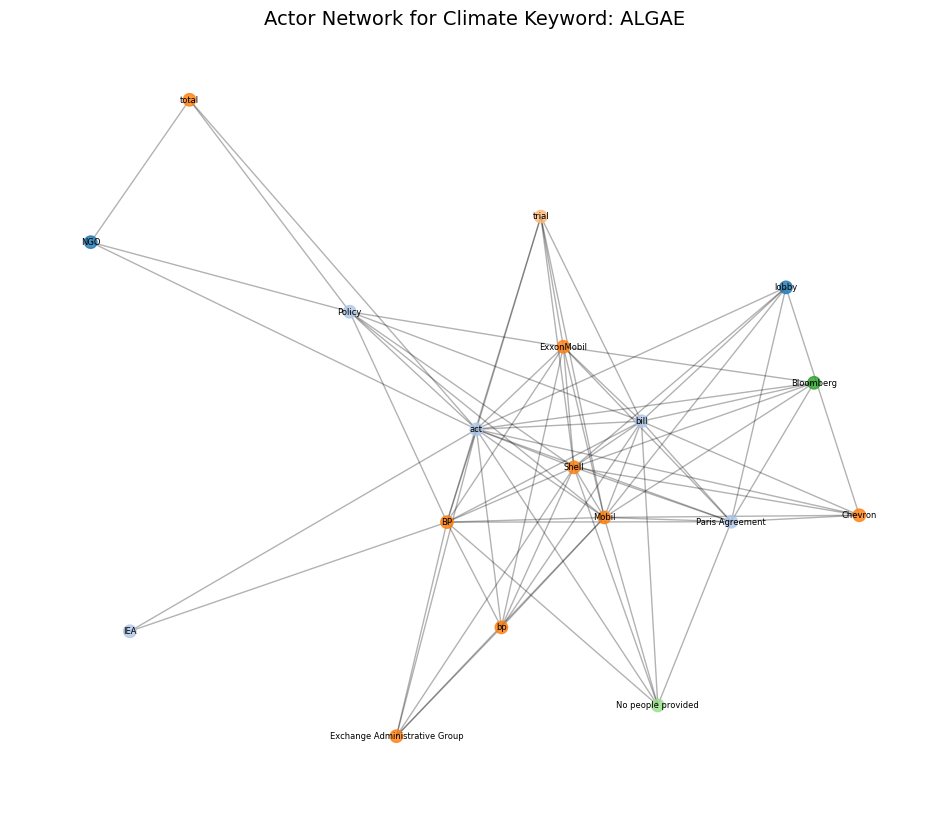


Building network for keyword: nuclear


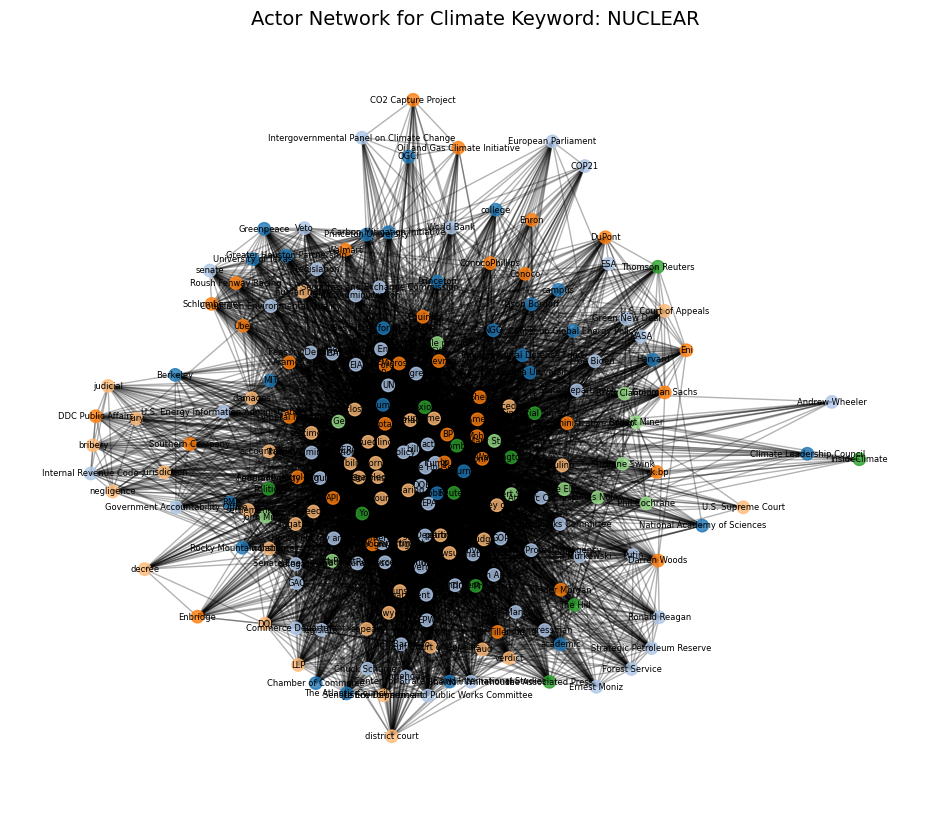


Building network for keyword: ccs


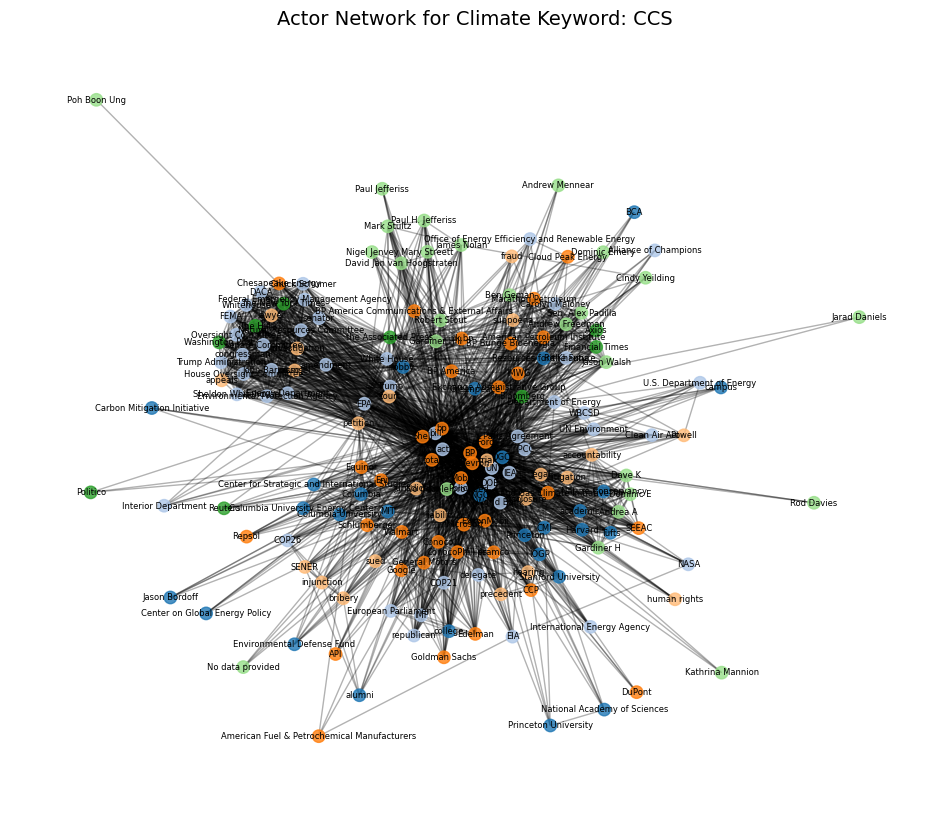


Building network for keyword: ccus


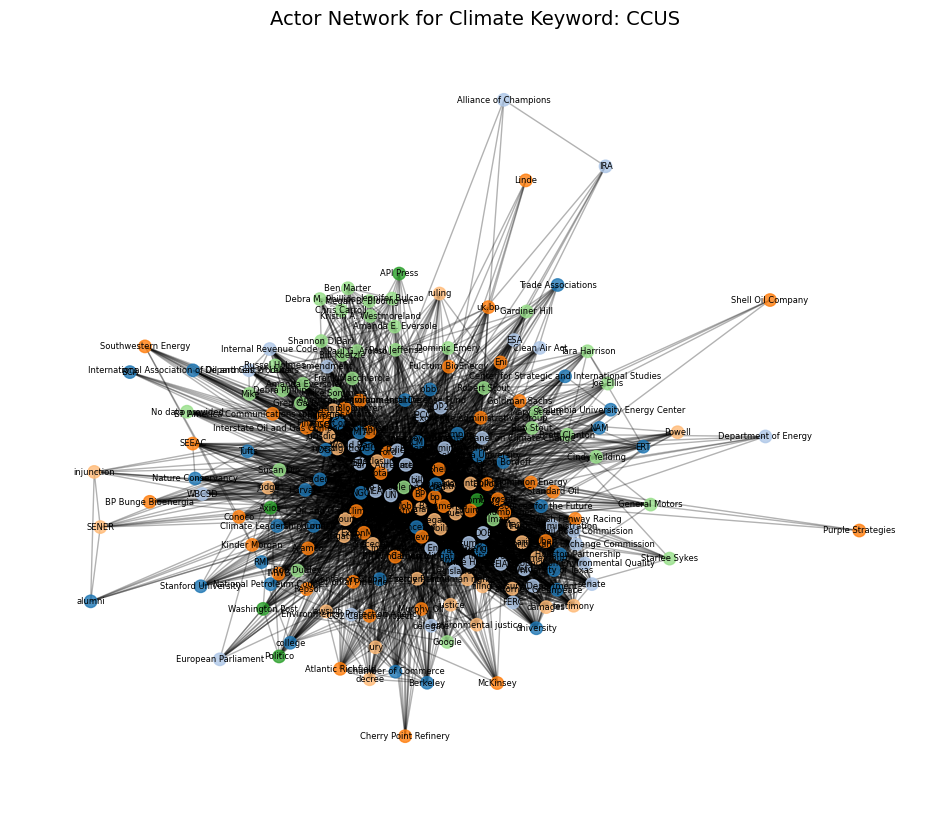

In [ ]:
# Keywords to include
target_keywords = {'nuclear', 'ccus', 'ccs', 'biofuels', 'algae', 'hydrogen'}

# Clean and split keyword list
filtered_docs['Climate_Keywords'] = filtered_docs['Climate_Keywords'].fillna('')
filtered_docs['Climate_Keyword_List'] = filtered_docs['Climate_Keywords'].apply(
    lambda x: [kw.strip().lower() for kw in x.split(';') if kw.strip()]
)

# Filter to docs that include any of the target keywords
keyword_docs = filtered_docs[
    filtered_docs['Climate_Keyword_List'].apply(lambda kws: any(k in target_keywords for k in kws))
].copy()

# Define actor columns and their delimiters
actor_columns = [
    'People', 'Academia', 'Consultancy', 'Courts', 'Energy Industry', 'Government Agency',
    'International Climate Governance', 'International Organization', 'Journalist',
    'Legal Professionals', 'Legislation', 'Litigation', 'Lobby',
    'NGO/Thinktank/Foundation', 'News Outlet', 'Other Industry', 'PR Company',
    'Politician', 'Advocacy_Research', 'Government_Policy', 'Industry_Business',
    'Judiciary', 'Media'
]
delimiters = {
    'People': ',',
    **{col: ';' for col in actor_columns if col != 'People'}
}

# Loop through each keyword
for keyword in target_keywords:
    print(f"\nBuilding network for keyword: {keyword}")

    # Subset for this keyword
    docs = keyword_docs[keyword_docs['Climate_Keyword_List'].apply(lambda kws: keyword in kws)].copy()
    if docs.empty:
        print(f"No documents found for keyword: {keyword}")
        continue

    # Step 1: Extract all actors with categories
    entity_records = []
    for idx, row in docs.iterrows():
        for col in actor_columns:
            raw_val = row.get(col)
            if pd.isna(raw_val):
                continue
            delimiter = delimiters[col]
            entities = [e.strip() for e in raw_val.split(delimiter) if e.strip() and e.strip().lower() != ['not specified','no data provided']]
            for entity in entities:
                entity_records.append({
                    'doc_id': idx,
                    'entity': entity,
                    'category': col
                })

    entity_df = pd.DataFrame(entity_records)

    # Step 2: Keep only top 200 actors
    top_entities = entity_df['entity'].value_counts().nlargest(200).index
    entity_df = entity_df[entity_df['entity'].isin(top_entities)]

    # Step 3: Build edges (only if actors co-occurred at least 2 times)
    edge_weights = defaultdict(int)
    for _, group in entity_df.groupby('doc_id'):
        entities = list(group['entity'].unique())
        for e1, e2 in combinations(sorted(entities), 2):
            edge_weights[(e1, e2)] += 1

    edge_weights = {pair: w for pair, w in edge_weights.items() if w >= 2}
    if not edge_weights:
        print(f"No strong edges for keyword: {keyword}")
        continue

    # Step 4: Create graph
    G = nx.Graph()
    for (e1, e2), weight in edge_weights.items():
        G.add_edge(e1, e2, weight=weight)

    entity_category_map = dict(zip(entity_df['entity'], entity_df['category']))
    node_colors = []
    category_colors = {}
    palette = plt.cm.tab20.colors
    for i, cat in enumerate(sorted(set(entity_category_map.values()))):
        category_colors[cat] = palette[i % len(palette)]

    for node in G.nodes():
        cat = entity_category_map.get(node, 'Other')
        G.nodes[node]['category'] = cat
        node_colors.append(category_colors.get(cat, 'gray'))

    # Step 5: Plot it
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42, k=0.3)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=80, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=6)
    plt.title(f"Actor Network for Climate Keyword: {keyword.upper()}", fontsize=14)
    plt.axis('off')
    plt.show()